# Times of India Article Display Interface

In [1]:
from toidisplay import display_requested_articles, load_metadata, binary_categorize
import pandas as pd

## Define Input functions:

If you have a list or custom script to output a list of articles, a custom input function to run after display of each article (say, a coding assignment), or  

In [2]:
# Add list-defining function here:  
# The provided sample takes an input csv, an output csv, and outputs a list of articles in the input list but not in the output list

input_list = pd.read_csv('sample_input.csv', index_col=0).index.to_list()
output_csv = 'article_output.csv'

## Define Input and Save functions (Optional)
If you would like to have a custom input function run after display (say, a coding assignment), and if you would like to save the results of the input function, add them in the cell below. Define them as linked_function() and save_function() respectively. If input_function remains undefined, the page will default to a "Press enter to continue" dialog box with no save function.

In [3]:
save_location = 'sample_output.csv'

## Display Articles

Here's article 5 of 15, in set 1 of 123:


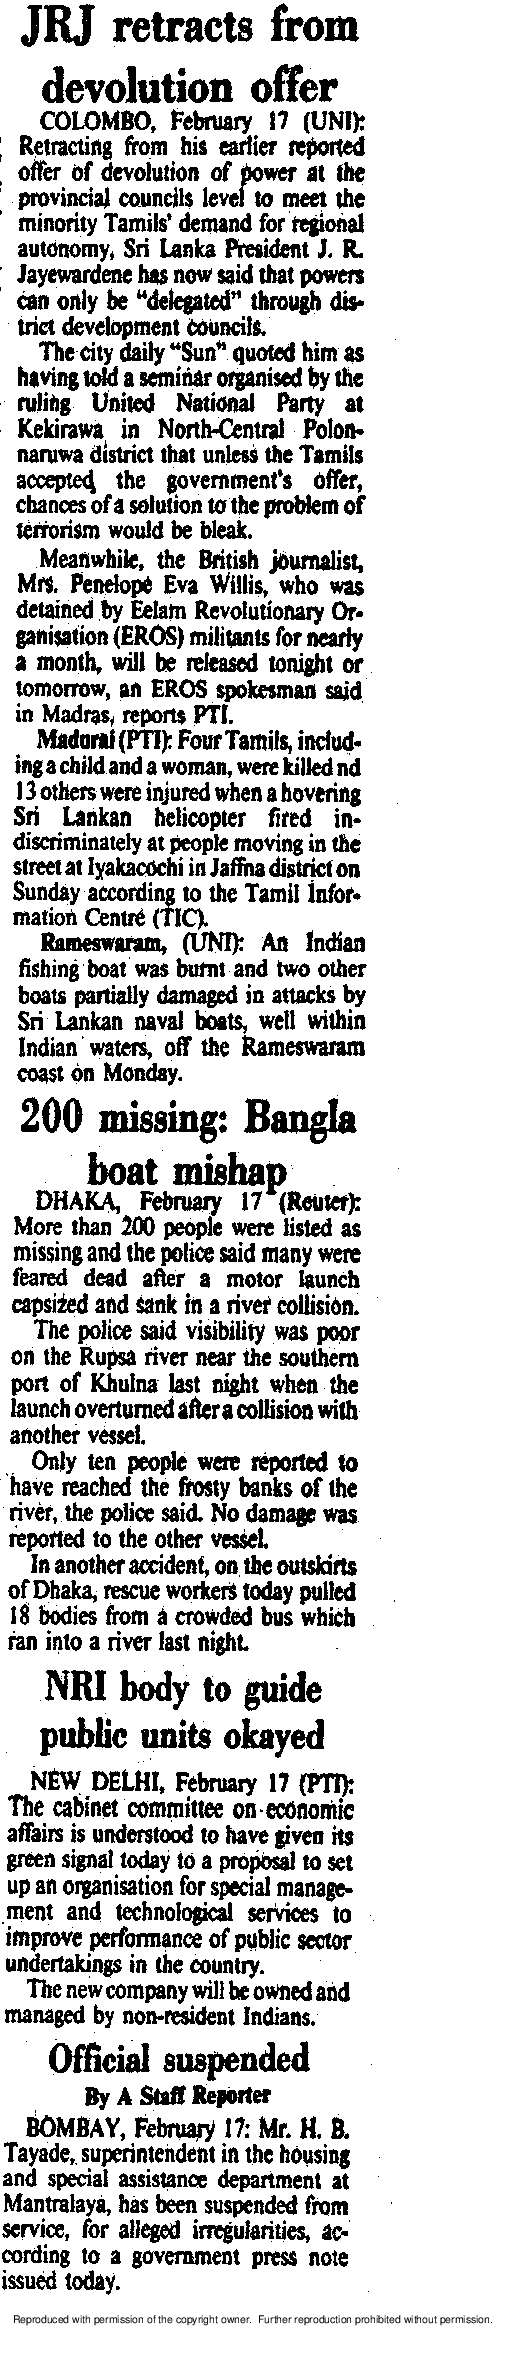

Article ID: 613658624 	 Published: 1986-02-18 00:00:00
Object Types:	 feature, article
I'm not sure how to interpret that.


KeyboardInterrupt: 

In [4]:
display_requested_articles(display_list=input_list, input_function=binary_categorize, chunk_size=15, append_mode=True, save_location=output_csv)